In [727]:
import sys # for automation and parallelization: set manual to false when run by a launcher
import json
default = {'scenario': 'base', 'training_folder':'../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

In [728]:
import os
import time
import geopandas as gpd
import pandas as pd
import numpy as np
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

num cores: 8


In [729]:
from syspy.skims.skims import euclidean

In [730]:
scenario = argv['scenario']

on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
print('On Lambda : ', on_lambda)

training_folder = argv['training_folder']
input_folder = training_folder +r'/inputs/'

if not on_lambda:
    scenario_folder = training_folder + '/scenarios/' + scenario  + '/inputs/'
    output_folder = training_folder + '/scenarios/' + scenario  + '/outputs/'
    model_folder = training_folder + '/scenarios/' + scenario  + '/model/'
else:
    scenario_folder = input_folder
    output_folder = training_folder + '/outputs/'
    model_folder = training_folder + '/model/'
print('input folder: ', input_folder)
print('output folder: ', output_folder)
print('scen folder : ', scenario_folder)
print('model folder : ', model_folder)

On Lambda :  False
input folder:  ../../inputs/
output folder:  ../../scenarios/base/outputs/
scen folder :  ../../scenarios/base/inputs/
model folder :  ../../scenarios/base/model/


In [731]:
if 'params' in argv.keys():
    var = excel.read_var(file=input_folder+'parameters.xlsx', scenario=scenario, return_ancestry=False)
    var.update(pd.DataFrame.from_dict(argv['params'], orient="index").stack())
else:
    var = excel.read_var(file=input_folder+'parameters.xlsx', scenario=scenario, return_ancestry=False)

In [732]:
motor_rate = var['generation']['motor_rate'] 
pt_rate = (1-motor_rate)

# Import model

In [733]:
sm = stepmodel.read_zippedpickles(model_folder +'aon_los')

zones: 100%|██████████| 5/5 [00:00<00:00, 1590.56it/s]


In [734]:
pop_a = var['generation']['pop_attraction']
job_a = var['generation']['job_attraction']
pop_p = var['generation']['pop_production']
job_p = var['generation']['job_production']

if var['generation']['all_period']:
    to_day =  var['generation']['to_day']
else:
    to_day = 1


sm.zones['emission'] =  (sm.zones['population']*pop_p + sm.zones['jobs']* job_p) *to_day 
sm.zones['attraction'] =  (sm.zones['jobs']* job_a + sm.zones['population']*pop_a) *to_day 
sm.zones.sort_index(inplace=True)

if var['generation']['correction_pa']:
    if not os.path.isfile(scenario_folder+'/calibration/pa_correction.csv' ):
        emissions_file = (scenario_folder+'/calibration/production_calib.csv' )
        attractions_file =(scenario_folder+'/calibration/attraction_calib.csv' )
        emissions_file_provided = os.path.isfile(emissions_file)
        attractions_file_provided = os.path.isfile(attractions_file)

        if emissions_file_provided and attractions_file_provided:
            emissions_calib = pd.read_csv(emissions_file, index_col=0)
            attractions_calib = pd.read_csv(attractions_file,index_col=0)

            pa_correction = sm.zones.merge(emissions_calib, left_index=True, right_index=True, how='left')
            pa_correction = pa_correction.merge(attraction_calib, left_index=True, right_index=True, how='left')
            pa_correction['correction_production'] = pa_correction['emission_calibration'] - pa_correction['emission']
            pa_correction['correction_attraction'] = pa_correction['attraction_calibration'] - pa_correction['attraction']
            if not os.path.exists(output_folder + 'pa_correction.csv'):
                pa_correction.to_csv(output_folder + 'pa_correction.csv')
            pa_correction.to_csv(scenario_folder+'/calibration/pa_correction.csv')    

    sm.zones['correction_production'] = pa_correction['correction_production']
    sm.zones['correction_attraction'] = pa_correction['correction_attraction']
    sm.zones['emission'] =  (sm.zones['population']*pop_p + sm.zones['jobs']* job_p) *to_day + sm.zones['correction_production']
    sm.zones['attraction'] =  (sm.zones['jobs']* job_a + sm.zones['population']*pop_a) *to_day + sm.zones['correction_attraction']
    sm.zones.sort_index(inplace=True)

'''
if production = attraction, to let people stay 

if var['step_distribution']['symmetrize_matrix']:
    sm.zones['emission'] =  (sm.zones['emission']+ sm.zones['attraction'])/2
    sm.zones['attraction'] =  sm.zones['emission']
'''


car = sm.copy()
car.zones[['attraction','emission']] *= motor_rate  
car.zones = car.zones.loc[car.car_los["origin"].unique()]

pt_captive = sm.copy()
pt_captive.zones[['attraction','emission']] *= pt_rate
pt_captive.zones = pt_captive.zones.loc[pt_captive.pt_los["origin"].unique()]

In [735]:
output_folder

'../../scenarios/base/outputs/'

In [736]:
def create_impendance_matrix(df,mode=None, b=None, n=None):
    #time devient en minute comme dans modelling transport
    cost_matrix =  df[ 
    ['origin', 'destination', 'time']
].set_index(['origin','destination']).unstack()
    
    cost_matrix = cost_matrix.replace(0,var['step_distribution']['time_intrazonal_{}'.format(mode)] ) 
    if n == None: n = var["step_distribution"]["n_{}".format(mode)]
    if b == None: b = var["step_distribution"]["b_{}".format(mode)]
    f_cost_matrix = cost_matrix.pow(n) * np.exp(- b *cost_matrix)
    
    #enorme temps pour detruire od sans tc dans pt captif
    f_cost_matrix = f_cost_matrix.fillna(1e16)
    
    imp_matrix = f_cost_matrix 
    
    return( imp_matrix )

In [737]:
if var['step_distribution']['distance_distribution']:
    from syspy.skims.skims import euclidean

    distances = euclidean(sm.zones, coordinates_unit='meter', epsg=4326)
    distances['time'] = distances['euclidean_distance'] / 5 + 300
    distances.loc[distances['origin'] == distances['destination'], 'time']= var['step_distribution']['time_intrazonal_car']
    distances = distances.sort_index()

In [738]:
if var['step_distribution']['distance_distribution'] : e = create_impendance_matrix(distances,'car')
else: e = create_impendance_matrix(car.car_los,'car')
e = e.sort_index(axis=0).sort_index(axis=1)
car.zones.sort_index(inplace=True)
e.sort_index(axis=1, inplace=True)
e.sort_index(axis=0, inplace=True)
car.step_distribution(deterrence_matrix = e) 

In [739]:
if var['step_distribution']['distance_distribution'] : e = create_impendance_matrix(distances,'pt')
else:e = create_impendance_matrix(pt_captive.pt_los,'pt')
e = e.sort_index(axis=0).sort_index(axis=1)
e.sort_index(axis=1, inplace=True)
e.sort_index(axis=0, inplace=True)
pt_captive.step_distribution(deterrence_matrix = e) 

In [740]:
sm.volumes = pd.merge(
    car.volumes, 
    pt_captive.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
).rename(columns={'volume_car_owner': 'car_owner', 'volume_pt_captive': 'pt_captive'})


In [741]:
sm.sample_volumes(bidimentional_sampling=True, fit_sums=True, sample_weight={'car_owner':50, 'pt_captive':5}, sample_size=None, inplace=True)

cannot fit both axis. c =  0.00892760665004344
cannot fit both axis. c =  0.00566337170500919


In [742]:
od_file = scenario_folder + 'od/od.geojson'
od_file_provided = os.path.isfile(od_file)
if od_file_provided:
    
    od_test = gpd.read_file(od_file, engine= io_engine)
    if 'name' not in od_test.columns:
        od_test['name'] = od_test['index']
    od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))
    from shapely.geometry import Point
    from syspy.spatial.spatial import nearest, agglomerative_clustering, voronoi_diagram_dataframes, add_geometry_coordinates
    od_test['geometry_o'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][0]))
    od_test['geometry_d'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][1]))
    # find nearest node with KNN. nodes are now the origin and destination.
    od_test['geometry'] = od_test['geometry_o']
    neigh = nearest(od_test, sm.zones.to_crs(4326), n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    od_test['origin'] = od_test.index.map(zone_node_dict.get)

    od_test['geometry'] = od_test['geometry_d']
    neigh = nearest(od_test, sm.zones.to_crs(4326), n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    od_test['destination'] = od_test.index.map(zone_node_dict.get)

    od_test = od_test.drop(columns=['geometry_o','geometry_d','geometry'])
    od_test["pt_captive"] = 0.001
    #Add od_test to volumes after sparsification
    sm.volumes = pd.concat([sm.volumes,od_test[["origin","destination","pt_captive"]]]).sort_values(by="pt_captive",ascending = False).drop_duplicates(["origin","destination"])


    sm.volumes= pd.concat([sm.volumes,od_test[["origin","destination","pt_captive"]]]).sort_values(by="pt_captive",ascending = False).drop_duplicates(["origin","destination"])

In [743]:
if var['step_distribution']['symmetrize_matrix']:
    transpose = sm.volumes.copy()
    transpose = transpose.rename(columns={'origin':'destination', 'destination':'origin'}).fillna(0)
    sym = (sm.volumes.set_index(['origin', 'destination']) + transpose.set_index(['destination', 'origin']))/2
    sm.volumes = sym.reset_index()
    

In [744]:
sm.to_zippedpickles(model_folder +'distribution', only_attributes= ['volumes', 'zones_before_clustering'])

volumes: 100%|██████████| 12/12 [00:00<00:00, 1058.25it/s]


In [745]:
if var["calibration"]["sortie"] == False:
    end_of_notebook

# Calibration

In [746]:
from syspy.spatial.spatial import nearest_geometry
import math
import matplotlib.pyplot as plt
from syspy.skims.skims import euclidean

In [747]:
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [748]:
def from_zone_before_clustering_to_zone(df,zones):
    df_calib = df.merge(zones,left_on = "origin", right_index = True, how = "left")
    df_calib = df_calib.merge(zones,left_on = "destination", right_index = True, how = "left",suffixes = ("_origin","_destination"))
    df_calib = df_calib[["cluster_origin","cluster_destination","volumes_calibration"]].rename(columns = {"cluster_origin" : "origin","cluster_destination" : "destination"})
    return(df_calib)
    
    return(df[["ratio", 'cluster']])
def near_nodes(nodes,zones,div_neighbors = 2):
    node_proxim = nearest_geometry(nodes,zones,n_neighbors = int(len(zones)/div_neighbors),n_neighbors_centroid = int(len(zones)/div_neighbors))
    node_proxim = node_proxim.sort_values(by = "actual_distance")
    node_proxim =  node_proxim.drop_duplicates(["ix_one"])
    return(node_proxim.set_index(["ix_one"])["ix_many"].to_dict())
def GEH(A, B):
    return ((2*(A-B)**2)/(A+B)).apply(math.sqrt)
def round_up(n, decimals=0):
    multiplier = 10**decimals/2
    return math.ceil(n * multiplier) / multiplier

In [749]:
zones_before_clustering = sm.zones_before_clustering.copy()
zones_before_clustering["cluster"] = 'zone_' + zones_before_clustering["cluster"].astype(str) 
zones = zones_before_clustering

In [750]:
sm.volumes = sm.volumes.fillna(0)
sm.volumes['volumes_model'] = sm.volumes['car_owner'] + sm.volumes['pt_captive']
sm.volumes = sm.volumes.groupby(['origin', 'destination']).sum()
sm.volumes = sm.volumes.reset_index()

# import donées calibration

In [751]:
calib_file = scenario_folder  + r'calibration/volume_od_calibration.csv'
calib_file_provided = os.path.isfile(calib_file)
if calib_file_provided:
    vol_od_calibration = pd.read_csv(calib_file)
    columns = ["volumes_model","volumes_calibration"]
    vol_od_calibration = from_zone_before_clustering_to_zone(vol_od_calibration,zones)
    vol_od_calibration = vol_od_calibration.dropna()
else :
    columns = ["volumes_model"]

In [752]:
emissions_file = scenario_folder  + r'calibration/emissions_calib.csv'
attractions_file = scenario_folder  + r'calibration/attractions_calib.csv'

emissions_file_provided = os.path.isfile(emissions_file)
attractions_file_provided = os.path.isfile(attractions_file)

if emissions_file_provided and attractions_file_provided:
    emissions_calib = pd.read_csv(emissions_file)
    attractions_calib = pd.read_csv(attractions_file)

    

### macrozones

In [753]:
macro_file = scenario_folder  + r'calibration/zones_macro.geojson'
macro_file_provided = os.path.isfile(macro_file)
if macro_file_provided:
    import shapely as shp
    macro_zones = gpd.read_file(macro_file, engine= io_engine).to_crs(sm.zones.crs)

    macro_zones = macro_zones.groupby("macro_zones")['geometry'].apply(shp.ops.cascaded_union)
    centroid = gpd.GeoDataFrame(sm.zones.centroid).rename(columns = {0:"geometry"})
    
    dico_macro_zones = near_nodes(centroid,macro_zones)

nearest_link: 100%|██████████| 464/464 [00:00<00:00, 262144.00it/s]


### distance

In [754]:
origins = sm.volumes['origin'].unique().tolist()
destinations = sm.volumes['destination'].unique().tolist()

distances = euclidean(sm.zones, coordinates_unit='meter', epsg=4326, origins=origins, destinations=destinations)
distances
distances['avg_dist'] = (distances['euclidean_distance']/1000)
distances['euclidean_distance'] = (distances['euclidean_distance']/1000).apply(lambda x: round_up(x,var['generation_calibration']['decimal_dist']))


# generation

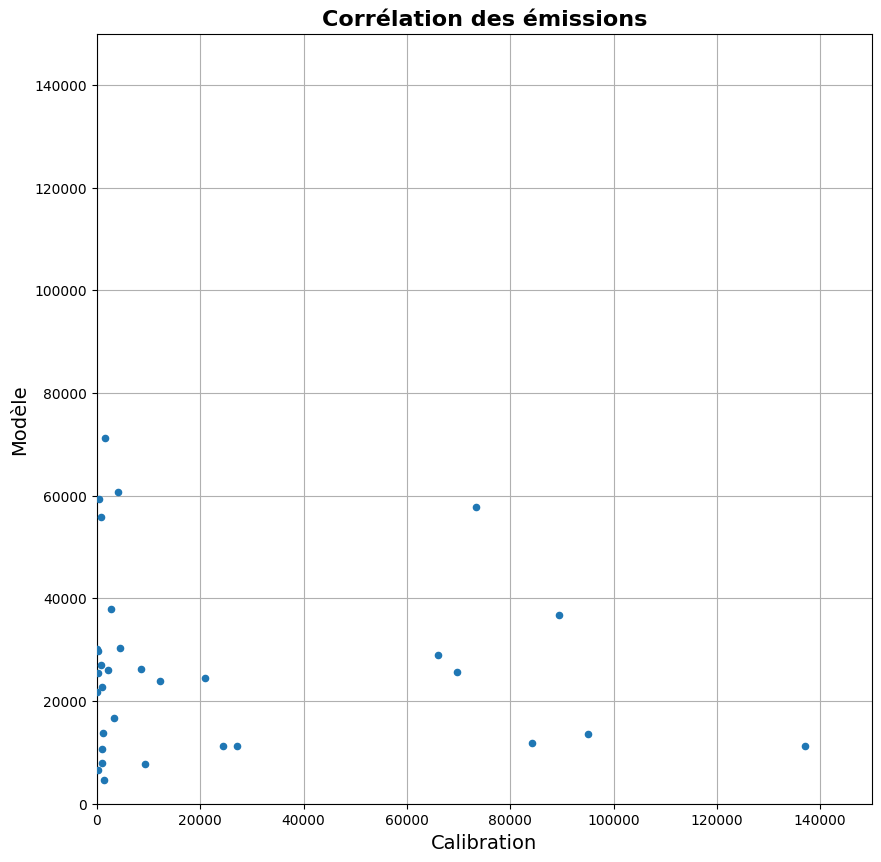

In [755]:
if calib_file_provided:
    sm.zones['emission_calibration'] = vol_od_calibration.groupby(['origin']).sum()
    sm.zones['attraction_calibration'] = vol_od_calibration.groupby(['destination']).sum()
    
    to_plot=sm.zones
    ax =  to_plot.plot.scatter(x='emission_calibration', y='emission', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)
    ax.grid(axis='both', zorder=3)
    plt.title('Corrélation des émissions',loc='center', fontsize=16, fontweight="bold")
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    ax.set_xlim(0,150000)
    ax.set_ylim(0,150000)
    fig = ax.get_figure()
    plt.savefig(output_folder+'01_Comparaison_emissions',bbox_inches='tight', dpi=150)

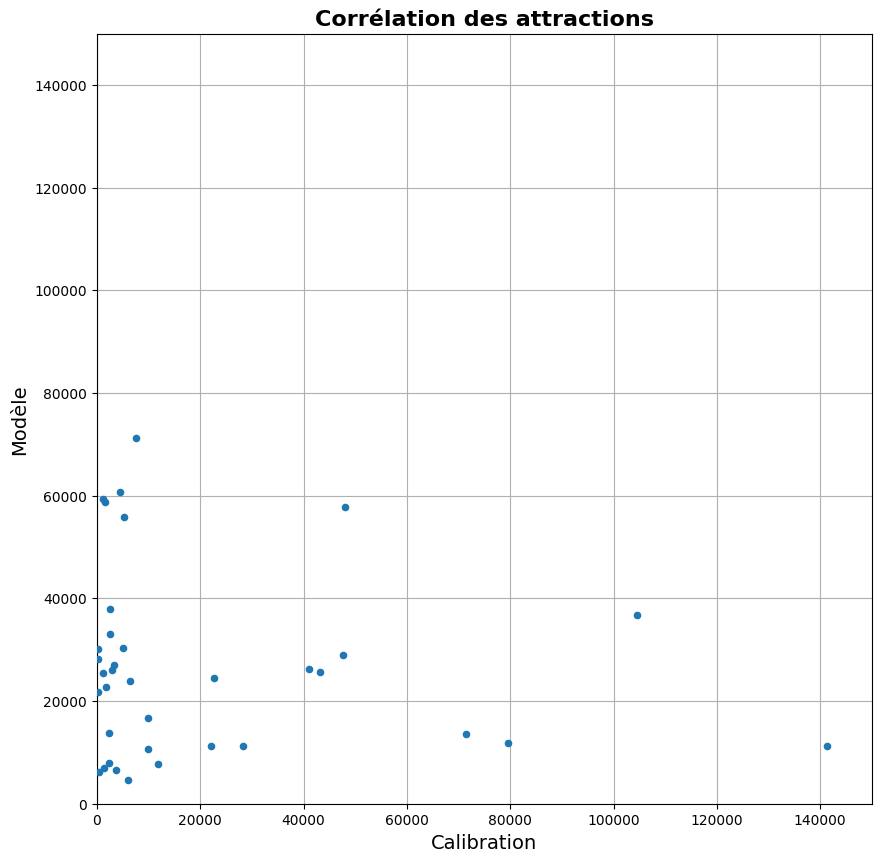

In [756]:
if calib_file_provided:
    to_plot=sm.zones
    ax =  to_plot.plot.scatter(x='attraction_calibration', y='attraction', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)
    ax.grid(axis='both', zorder=3)
    plt.title('Corrélation des attractions',loc='center', fontsize=16, fontweight="bold")
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    ax.set_xlim(0,150000)
    ax.set_ylim(0,150000)
    fig = ax.get_figure()
    plt.savefig(output_folder+'02_Comparaison_attractions',bbox_inches='tight', dpi=150)

In [757]:
'''
emissions_file = (scenario_folder+'/calibration/production_calib.csv' )
attractions_file =(scenario_folder+'/calibration/attraction_calib.csv' )

emissions_file_provided = os.path.isfile(emissions_file)
attractions_file_provided = os.path.isfile(attractions_file)

if emissions_file_provided and attractions_file_provided:
    emissions_calib = pd.read_csv(emissions_file)
    attractions_calib = pd.read_csv(attractions_file)


    if not os.path.exists(output_folder + 'pa_correction.csv'): # or si c<est pas dans input folder ausso

        attractions_calib = attractions_calib.merge(zones_before_clustering['cluster'], left_on='destination', right_index=True)
        emissions_calib = emissions_calib.merge(zones_before_clustering['cluster'], left_on='origin', right_index=True)

        attractions_calib = attractions_calib.set_index('cluster').rename_axis('index')
        emissions_calib = emissions_calib.set_index('cluster').rename_axis('index')

        emissions = pd.DataFrame(sm.zones['emission'])
        attractions = pd.DataFrame(sm.zones['attraction'])
        emissions_attractions = emissions.merge(attractions, left_index=True, right_index=True, how='inner')
        emissions_attractions['emission_calibration'] = emissions_calib['volumes_calibration']
        emissions_attractions['attraction_calibration'] = attractions_calib['volumes_calibration']
        emissions_attractions['correction_production'] = emissions_attractions['emission_calibration'] - emissions_attractions['emission']
        emissions_attractions['correction_attraction'] = emissions_attractions['attraction_calibration'] - emissions_attractions['attraction']
        emissions_attractions[['correction_production', 'correction_attraction']] =  emissions_attractions[['correction_production', 'correction_attraction']].fillna(0)
        emissions_attractions.to_csv(output_folder + 'pa_correction.csv')

        emissions_attractions = emissions_attractions.merge(sm.zones_poly['geometry'], right_index=True, left_index=True)
        gpd.GeoDataFrame(emissions_attractions).to_crs(epsg=4326).to_file(output_folder +'zones_correction.geojson', driver='GeoJSON')
    '''

"\nemissions_file = (scenario_folder+'/calibration/production_calib.csv' )\nattractions_file =(scenario_folder+'/calibration/attraction_calib.csv' )\n\nemissions_file_provided = os.path.isfile(emissions_file)\nattractions_file_provided = os.path.isfile(attractions_file)\n\nif emissions_file_provided and attractions_file_provided:\n    emissions_calib = pd.read_csv(emissions_file)\n    attractions_calib = pd.read_csv(attractions_file)\n\n\n    if not os.path.exists(output_folder + 'pa_correction.csv'): # or si c<est pas dans input folder ausso\n\n        attractions_calib = attractions_calib.merge(zones_before_clustering['cluster'], left_on='destination', right_index=True)\n        emissions_calib = emissions_calib.merge(zones_before_clustering['cluster'], left_on='origin', right_index=True)\n\n        attractions_calib = attractions_calib.set_index('cluster').rename_axis('index')\n        emissions_calib = emissions_calib.set_index('cluster').rename_axis('index')\n\n        emissions =

In [758]:
sm.zones.corr()

,density,population,jobs,emission,attraction,emission_calibration,attraction_calibration
density,1.000000,0.624920,0.095478,0.592367,0.592367,-0.209546,-0.186137
population,0.624920,1.000000,0.332071,0.982904,0.982904,-0.218364,-0.233644
jobs,0.095478,0.332071,1.000000,0.500067,0.500067,0.395235,0.456026
emission,0.592367,0.982904,0.500067,1.000000,1.000000,-0.106185,-0.116035
attraction,0.592367,0.982904,0.500067,1.000000,1.000000,-0.106185,-0.116035
emission_calibration,-0.209546,-0.218364,0.395235,-0.106185,-0.106185,1.000000,0.953024
attraction_calibration,-0.186137,-0.233644,0.456026,-0.116035,-0.116035,0.953024,1.000000


## Volume totaux

In [759]:
# paramètres utilisables pour modifier
var["generation"]

parameter
correction_pa     False
motor_rate          0.5
pop_attraction      1.5
job_attraction      0.5
pop_production      1.5
job_production      0.5
to_day                1
all_period        False
Name: base, dtype: object

In [760]:
if calib_file_provided:
    print(' Calibration:'+ (vol_od_calibration["volumes_calibration"].sum().round(-4)).astype(str) + '\n','Model:'+ sm.volumes['volumes_model'].sum().round(-4).astype(str) + '\n','Rapport Calibration/Model:' + ((vol_od_calibration['volumes_calibration'].sum()/sm.volumes['volumes_model'].sum()).round(3)).astype(str) + '\n' )

else: 
     print('Model:'+ sm.volumes['volumes_model'].sum().round(-4).astype(str))

 Calibration:740000.0
 Model:1310000.0
 Rapport Calibration/Model:0.566



# comparaison OD 

In [761]:
# paramètres utilisables pour modifier
var["step_distribution"]

parameter
symmetrize_matrix        False
distance_distribution    False
n_car                        1
n_pt                         1
b_car                     0.01
b_pt                      0.01
time_intrazonal_car       1000
time_intrazonal_pt        1000
Name: base, dtype: object

In [762]:
if calib_file_provided:
    comp_volumes = vol_od_calibration.groupby(["origin","destination"]).sum().reset_index().merge(sm.volumes[['origin', 'destination','volumes_model']], on = ['origin', 'destination'], how= 'outer')
    if macro_file_provided:
            comp_volumes_macro = comp_volumes.copy()
            comp_volumes_macro["origin"] = comp_volumes_macro["origin"].apply(lambda x : dico_macro_zones[x])
            comp_volumes_macro["destination"] = comp_volumes_macro["destination"].apply(lambda x : dico_macro_zones[x])
            comp_volumes_macro = comp_volumes_macro.groupby(["origin", "destination"], as_index=False)[columns].sum()
            comp_volumes_macro.corr()
else:
    comp_volumes = sm.volumes[['origin', 'destination','volumes_model']]


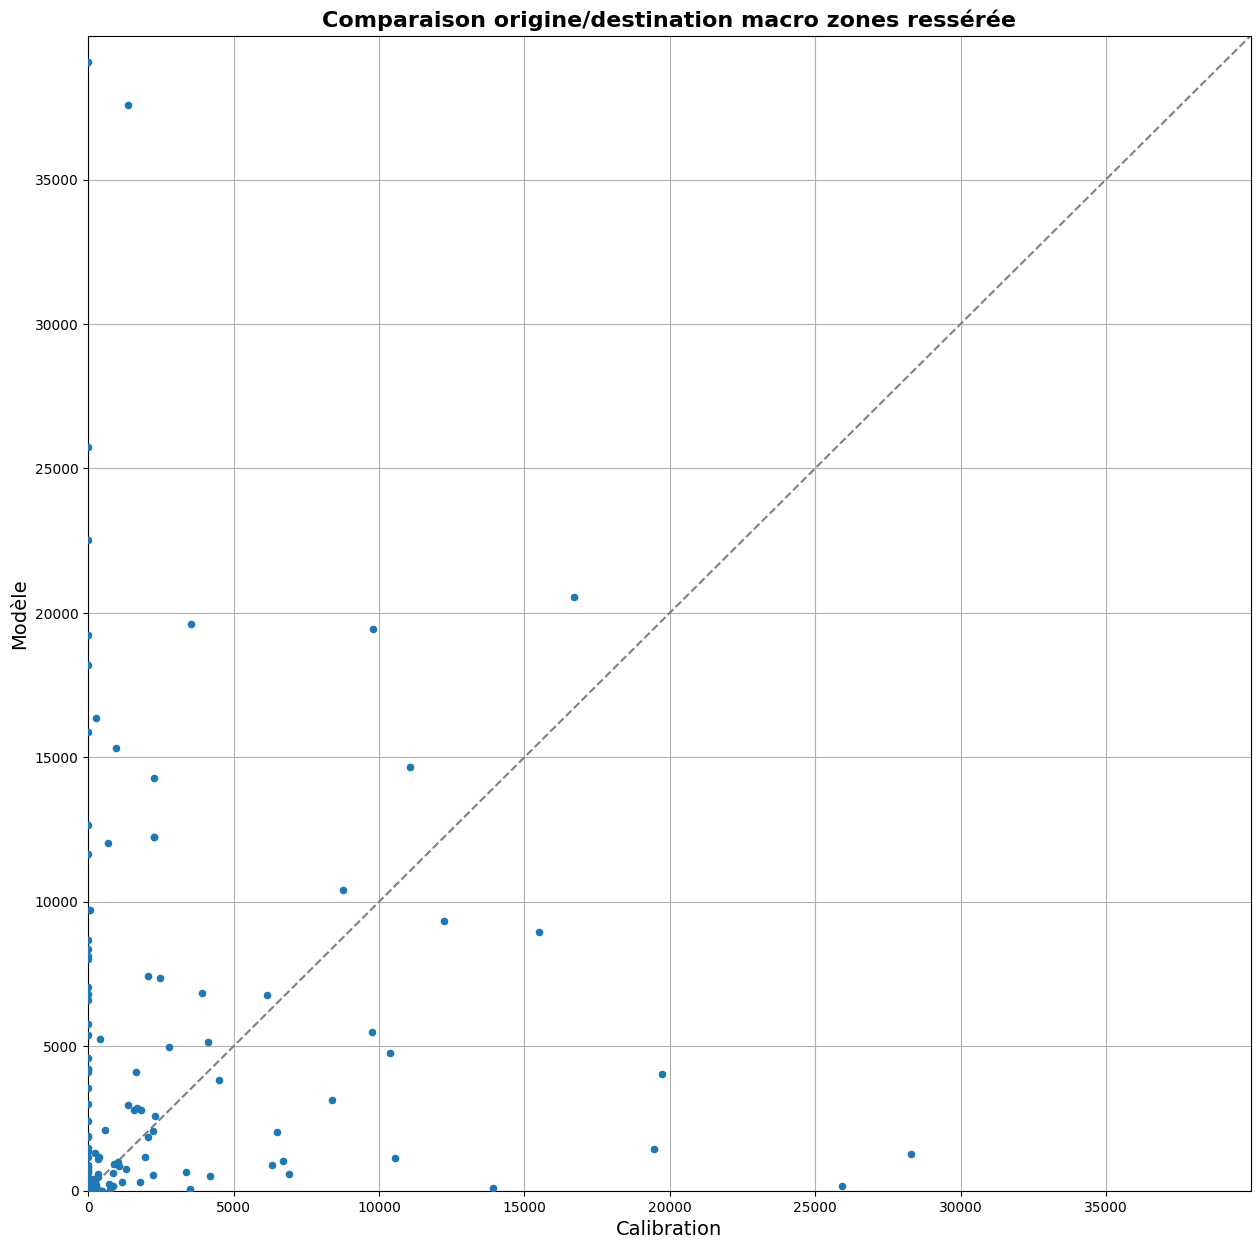

In [763]:
if calib_file_provided and macro_file_provided: 
    to_plot = comp_volumes_macro.set_index(['origin', 'destination'])
    ycol= 'volumes_model'
    xcol= 'volumes_calibration'
    to_plot['GEH'] = GEH(to_plot[ycol], to_plot[xcol])
    ax =  to_plot.plot.scatter(x=xcol, y=ycol, figsize=[15, 15], zorder=3, cmap='viridis')

    t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
    plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
    plt.xlim([0., max(to_plot[xcol].quantile(0.95),to_plot[ycol].quantile(0.95))+500])
    plt.ylim([0., max(to_plot[xcol].quantile(0.95),to_plot[ycol].quantile(0.95))+500])
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    
    ax.grid(axis='both', zorder=3)
    plt.title('Comparaison origine/destination macro zones ressérée', loc='center', fontsize=16, fontweight="bold")
    fig = ax.get_figure()
    plt.savefig(output_folder+'03_Comparaison_od_ressérée.png',bbox_inches='tight', dpi=150)

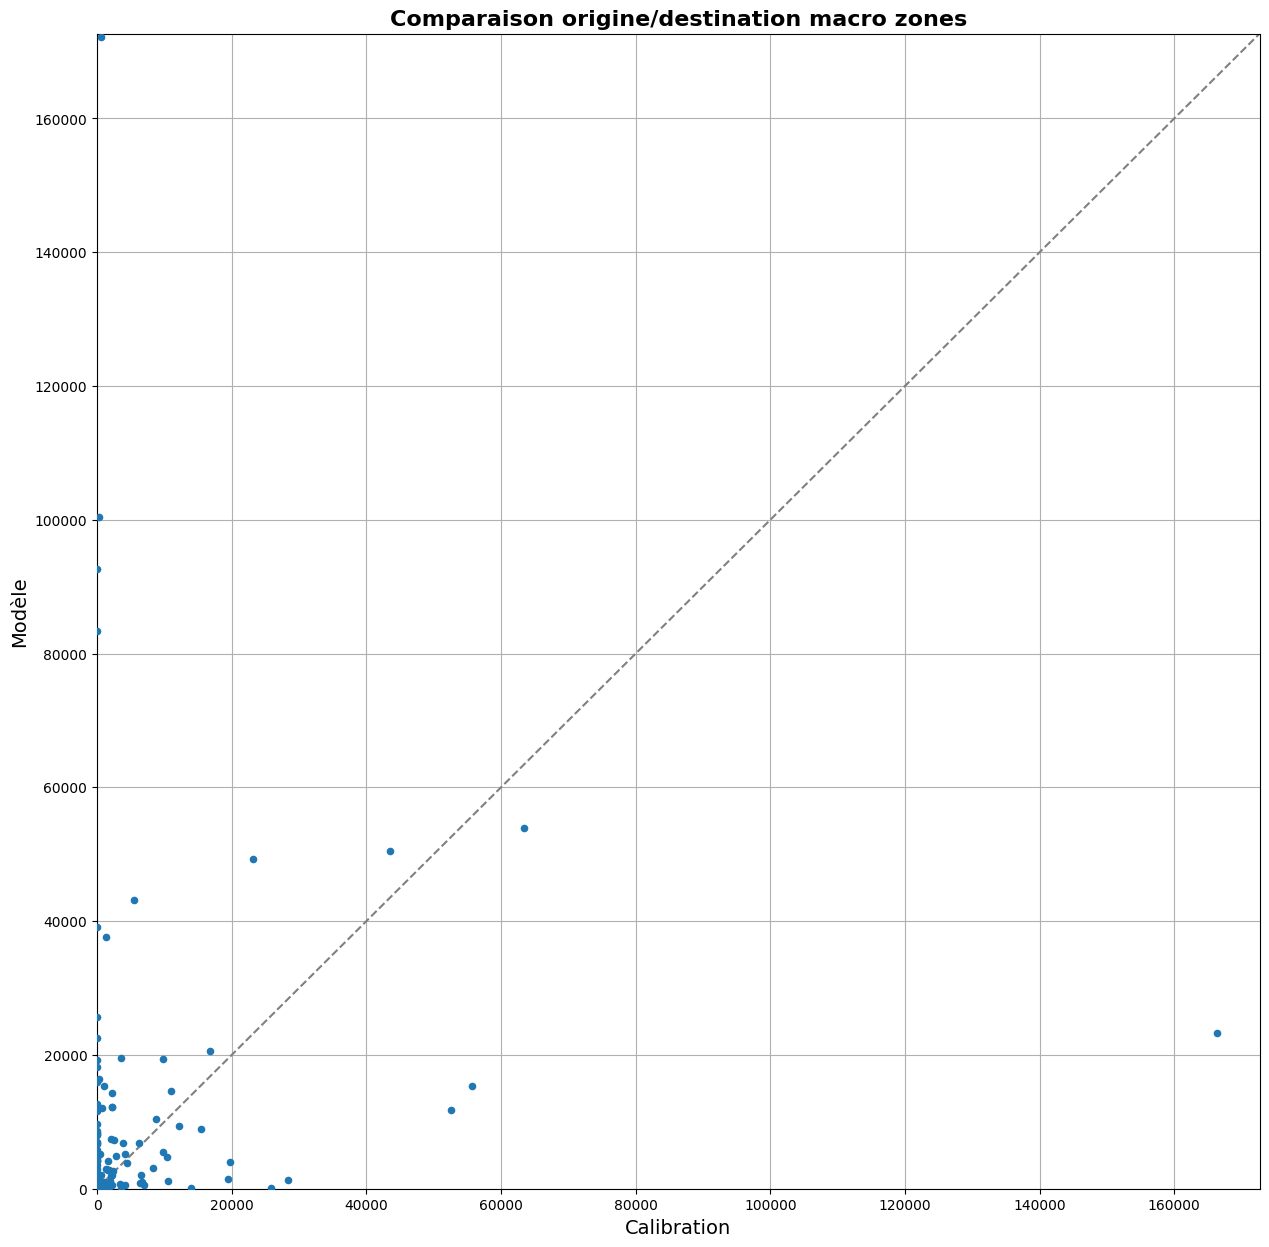

In [764]:
if calib_file_provided and macro_file_provided: 
    to_plot = comp_volumes_macro.set_index(['origin', 'destination'])
    ycol= 'volumes_model'
    xcol= 'volumes_calibration'
    to_plot['GEH'] = GEH(to_plot[ycol], to_plot[xcol])
    ax =  to_plot.plot.scatter(x=xcol, y=ycol, figsize=[15, 15], zorder=3, cmap='viridis')

    t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
    plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
    plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
    plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    
    ax.grid(axis='both', zorder=3)
    plt.title('Comparaison origine/destination macro zones', loc='center', fontsize=16, fontweight="bold")
    
    fig = ax.get_figure()
    plt.savefig(output_folder+'04_Comparaison_od_macro.png',bbox_inches='tight', dpi=150)

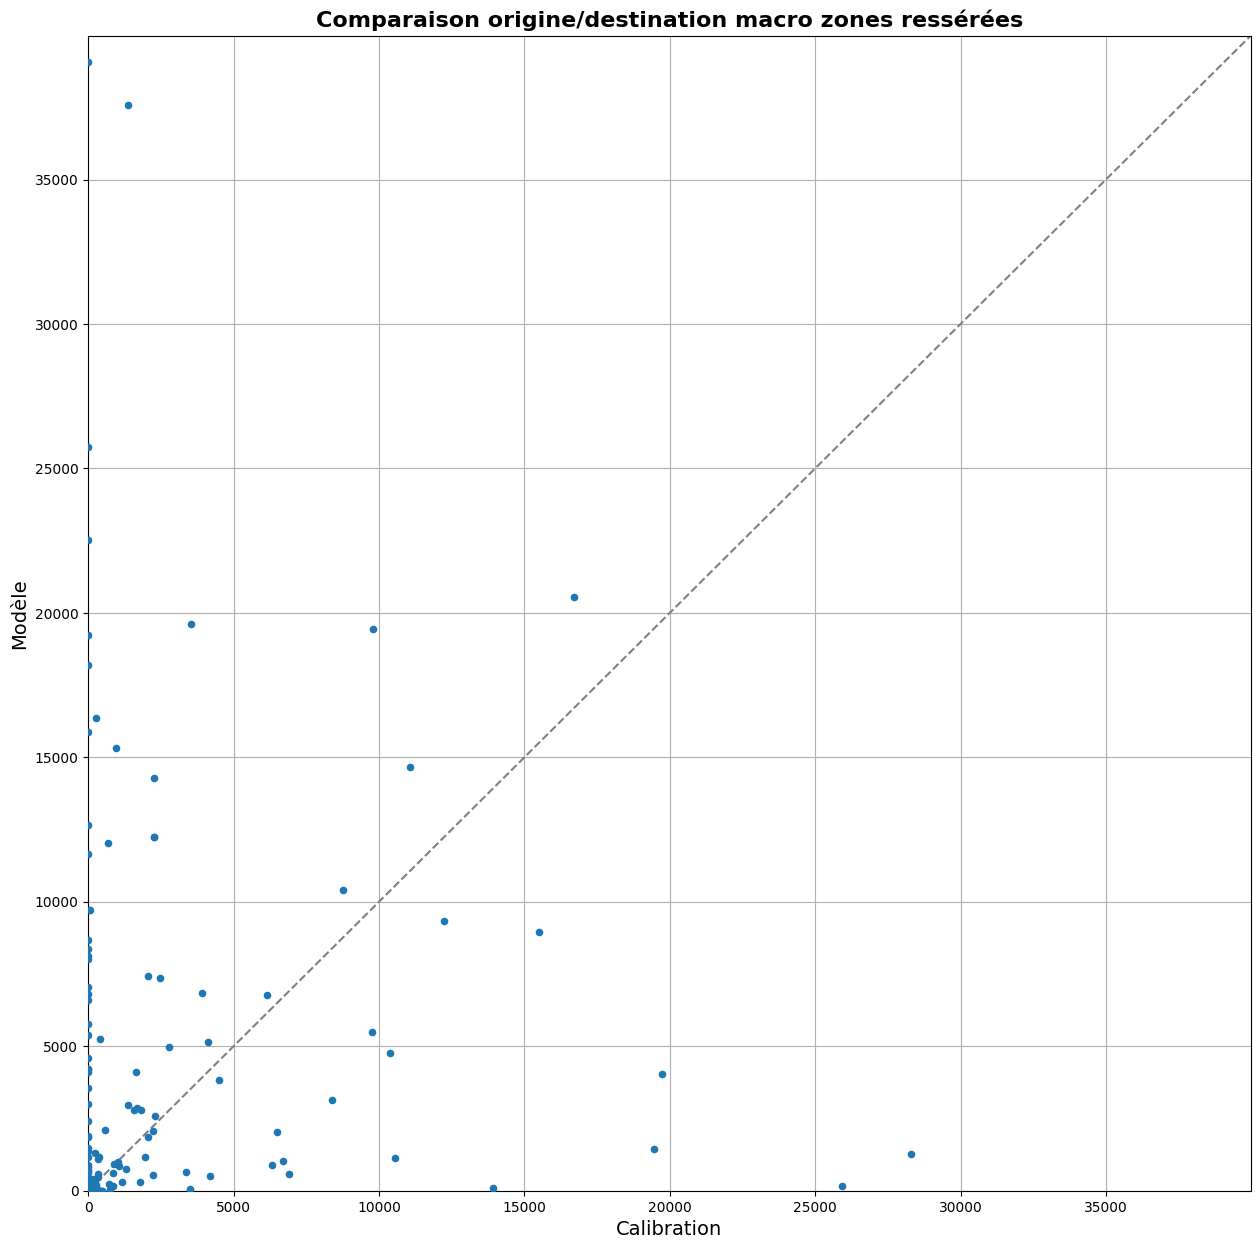

In [765]:
if calib_file_provided and macro_file_provided: 
    to_plot = comp_volumes_macro.set_index(['origin', 'destination'])
    ycol= 'volumes_model'
    xcol= 'volumes_calibration'
    to_plot['GEH'] = GEH(to_plot[ycol], to_plot[xcol])
    ax =  to_plot.plot.scatter(x=xcol, y=ycol, figsize=[15, 15], zorder=3, cmap='viridis')

    t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
    plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
    plt.xlim([0., max(to_plot[xcol].quantile(0.95),to_plot[ycol].quantile(0.95))+500])
    plt.ylim([0., max(to_plot[xcol].quantile(0.95),to_plot[ycol].quantile(0.95))+500])
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    
    ax.grid(axis='both', zorder=3)
    plt.title('Comparaison origine/destination macro zones ressérées', loc='center', fontsize=16, fontweight="bold")
    fig = ax.get_figure()
    plt.savefig(output_folder+'05_Comparaison_od_ressérée.png',bbox_inches='tight', dpi=150)

In [766]:
if calib_file_provided and macro_file_provided: 
    comp_volumes_macro['delta'] = comp_volumes_macro['volumes_model'] - comp_volumes_macro['volumes_calibration']
    comp_volumes_macro[['origin', 'destination', 'delta']].set_index(['origin','destination']).unstack()

# distance

In [767]:
comp_volumes = comp_volumes.merge(distances[['origin', 'destination', 'euclidean_distance', 'avg_dist']],on = ["origin","destination"], how ="left")
comp_volumes_dist = comp_volumes.groupby('euclidean_distance').agg({'volumes_model':'sum', 'volumes_calibration':'sum', 'avg_dist':'mean'})

In [768]:
if calib_file_provided:
    comp_volumes_dist['volumes_model'] *= comp_volumes_dist['volumes_calibration'].sum() / comp_volumes_dist['volumes_model'].sum()
    comp_volumes_dist['volumes_calibration'] = comp_volumes_dist['volumes_calibration']/comp_volumes_dist['volumes_calibration'].sum()

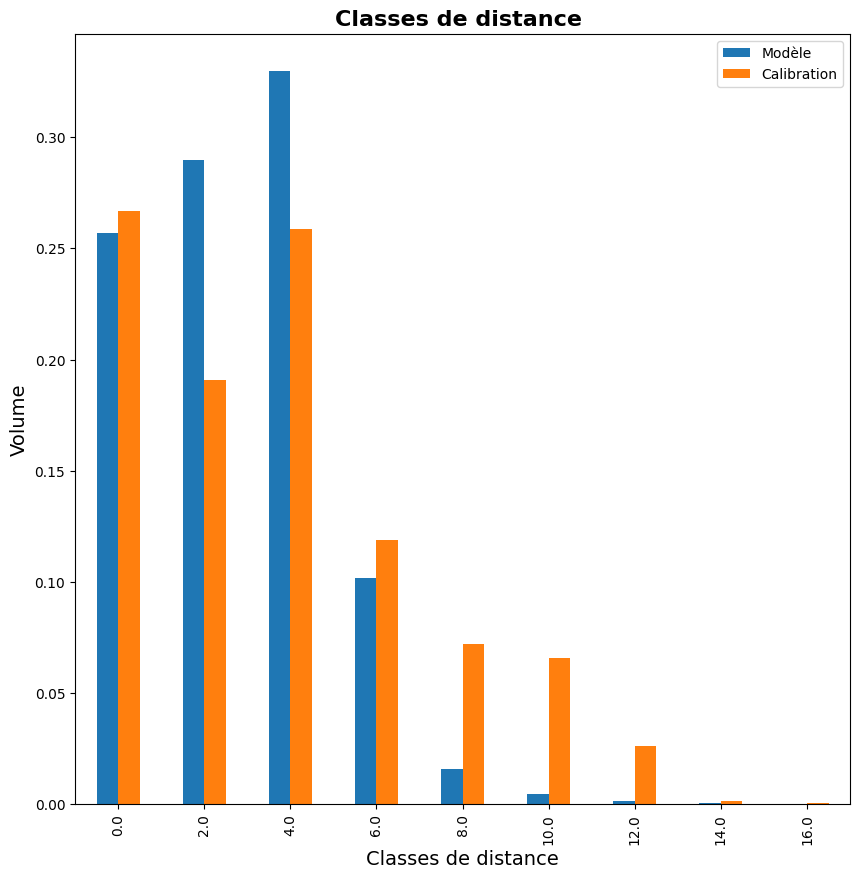

In [769]:
comp_volumes_dist['volumes_model'] = comp_volumes_dist['volumes_model']/comp_volumes_dist['volumes_model'].sum()
to_plot = comp_volumes_dist[['volumes_model', 'volumes_calibration']]#.plot( kind = 'bar', figsize=[10, 10])
ax =  to_plot.plot.bar(figsize=[10, 10])
plt.ylabel('Volume', fontsize=14)
plt.xlabel('Classes de distance', fontsize=14)
plt.title('Classes de distance ', loc='center', fontsize=16, fontweight="bold")
plt.legend( ['Modèle', 'Calibration'])
fig = ax.get_figure()
plt.savefig(output_folder+'06_Comparaison_volumes_distances.png',bbox_inches='tight', dpi=150)

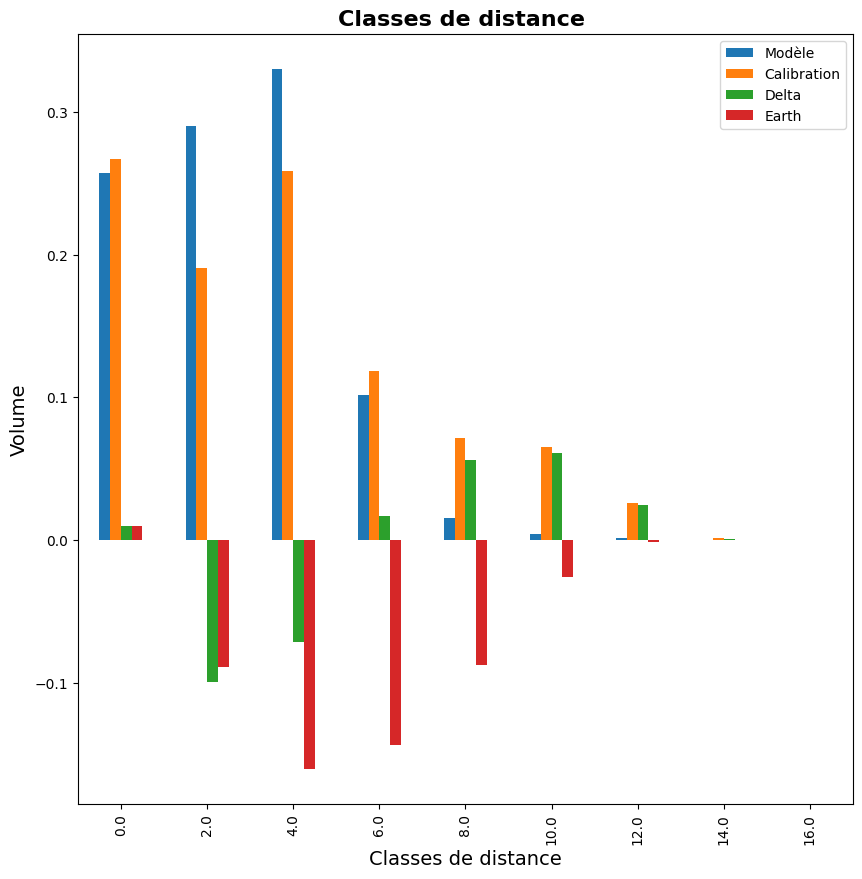

In [770]:
if calib_file_provided :    
    comp_volumes_dist = comp_volumes_dist[['volumes_model', 'volumes_calibration']]
    comp_volumes_dist['delta'] = comp_volumes_dist['volumes_calibration'].fillna(0) - comp_volumes_dist['volumes_model'].fillna(0)
    comp_volumes_dist ['earth'] = comp_volumes_dist['delta'].cumsum()
    to_plot = comp_volumes_dist#.plot( kind = 'bar', figsize=[10, 10])
    ax =  to_plot.plot.bar(figsize=[10, 10])
    plt.ylabel('Volume', fontsize=14)
    plt.xlabel('Classes de distance', fontsize=14)
    plt.title('Classes de distance ', loc='center', fontsize=16, fontweight="bold")
    plt.legend( ['Modèle', 'Calibration', 'Delta', 'Earth'])
    fig = ax.get_figure()
    plt.savefig(output_folder+'07_Comparaison_volumes_distances_earth.png',bbox_inches='tight', dpi=150)

In [771]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined